In [1]:
from train import *
from addict import Dict
import logging
from utils.construct_tff import construct_real_tff
import matplotlib.pyplot as plt
from utils.data_utils import get_loader
!export CUDA_VISIBLE_DEVICES=4

In [2]:
logger = logging.getLogger(__name__)

In [3]:
args = Dict()
args.model_type = 'ViT-B_16'
args.dataset = 'inet1k_cats'
args.img_size = 224
args.pretrained_dir = 'checkpoint/ViT-B_16.npz'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args.device = device
args.local_rank = -1
args.train_batch_size = 128 
args.eval_batch_size = 128

# args.dataset = 'inet1k_cats'
# args.dataset_dir = 'data/inet1k_classes/cats'
# ckpt_path = 'output/inet1k_cats-2023-10-02-22-19-15/inet1k_cats_final_ckpt.bin' 
# args.dataset = 'inet1k_birds'
# args.dataset_dir = 'data/inet1k_classes/birds'
# ckpt_path = 'output/inet1k_birds-2023-10-02-22-25-22/inet1k_birds_final_ckpt.bin'
# args.dataset = 'inet1k_dogs'
# args.dataset_dir = 'data/inet1k_classes/dogs'
# ckpt_path = 'output/inet1k_dogs-2023-09-24-21-00-17/inet1k_dogs_final_ckpt.bin'
# args.dataset = 'inet1k_snakes'
# args.dataset_dir = 'data/inet1k_classes/snakes'
# ckpt_path = 'output/inet1k_snakes-2023-10-02-22-28-06/inet1k_snakes_final_ckpt.bin'
args.dataset = 'inet1k_trucks'
args.dataset_dir = 'data/inet1k_classes/trucks'
ckpt_path = 'output/inet1k_trucks-2023-09-24-20-47-28/inet1k_trucks_final_ckpt.bin'

In [4]:
k_attn = 384
l_attn = 2
n_attn = 768
tffs = construct_real_tff(k_attn, l_attn // 2, n_attn // 2).to(args.device)
frame_cat = tffs.view(-1, n_attn)

In [7]:
tffs[0]
print(torch.dot(tffs[0,0], tffs[0,1]))
print(torch.dot(tffs[0,0], tffs[1,0]))

tensor(0., device='cuda:0')
tensor(0., device='cuda:0')


In [21]:
# percent of frames to keep
frame_percents = np.arange(1,0, -0.1)
print(frame_percents)

[1.  0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.2 0.1]


In [22]:
train_loader, test_loader = get_loader(args)

In [23]:
val_accs = []
norm_percents = []
for frame_percent in frame_percents:
    frames_count = int(frame_percent * k_attn)

    args, model = setup(args)
    model.load_state_dict(torch.load(ckpt_path))
    norm_percent = 0
    weight_count = 0
    for (name, param) in model.named_parameters():
        if 'attn' in name:
            if 'weight' in name:
                U, S, Vh = torch.linalg.svd(param)
                RotMat = U @ frame_cat
                new_projs = torch.matmul(tffs, RotMat.transpose(0,1) ) @ param
                new_norms = torch.norm(new_projs, dim=(1,2))
                new_norms_sorted, indices = torch.sort(new_norms, descending=True)
                norm_percent += torch.sqrt((new_norms_sorted[:frames_count]**2).sum()/(new_norms**2).sum())
                weight_count += 1

                new_frames_filtered = tffs[indices[:frames_count]].view(-1,n_attn)
                new_proj_mat = new_frames_filtered.transpose(0,1) @ new_frames_filtered
                param.data = new_proj_mat @ param.data 

    norm_percents.append(norm_percent.item() /(weight_count))
    val_acc = valid(args, model, writer=None, test_loader=test_loader, global_step=0)
    val_accs.append(val_acc)

    print(f'{frame_percent = }, norm_percent = {norm_percents[-1]} {val_acc = }')


85.80327


Validating... (loss=0.18635): 100%|| 13/13 [00:04<00:00,  2.68it/s]


frame_percent = 1.0, norm_percent = 1.0 val_acc = 0.9893081761006289
85.80327


Validating... (loss=0.16497): 100%|| 13/13 [00:04<00:00,  2.68it/s]


frame_percent = 0.9, norm_percent = 0.9997227986653646 val_acc = 0.9823899371069182
85.80327


Validating... (loss=0.54738): 100%|| 13/13 [00:04<00:00,  2.67it/s]


frame_percent = 0.8, norm_percent = 0.997952938079834 val_acc = 0.8635220125786164
85.80327


Validating... (loss=1.80556): 100%|| 13/13 [00:04<00:00,  2.68it/s]


frame_percent = 0.7000000000000001, norm_percent = 0.9933591683705648 val_acc = 0.44150943396226416
85.80327


Validating... (loss=1.84702): 100%|| 13/13 [00:04<00:00,  2.68it/s]


frame_percent = 0.6000000000000001, norm_percent = 0.984609842300415 val_acc = 0.23647798742138365
85.80327


Validating... (loss=1.84056): 100%|| 13/13 [00:04<00:00,  2.66it/s]


frame_percent = 0.5000000000000001, norm_percent = 0.9694366455078125 val_acc = 0.20566037735849058
85.80327


Validating... (loss=1.83552): 100%|| 13/13 [00:04<00:00,  2.64it/s]


frame_percent = 0.40000000000000013, norm_percent = 0.9436531861623129 val_acc = 0.18930817610062894
85.80327


Validating... (loss=1.88677): 100%|| 13/13 [00:04<00:00,  2.68it/s]


frame_percent = 0.30000000000000016, norm_percent = 0.9026191234588623 val_acc = 0.18490566037735848
85.80327


Validating... (loss=1.77047): 100%|| 13/13 [00:04<00:00,  2.67it/s]


frame_percent = 0.20000000000000018, norm_percent = 0.8313820362091064 val_acc = 0.20314465408805032
85.80327


Validating... (loss=1.75713): 100%|| 13/13 [00:04<00:00,  2.67it/s]

frame_percent = 0.1000000000000002, norm_percent = 0.6976099809010824 val_acc = 0.1792452830188679


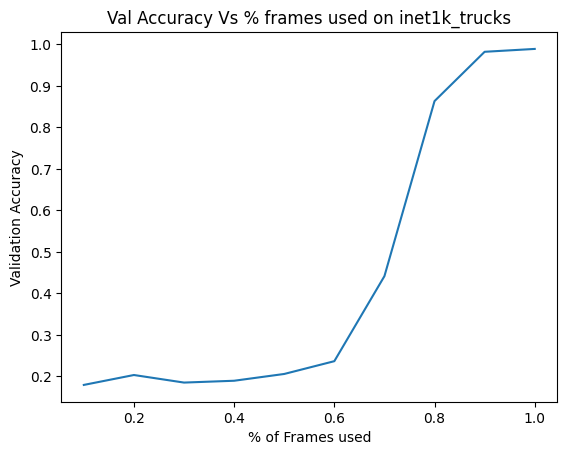

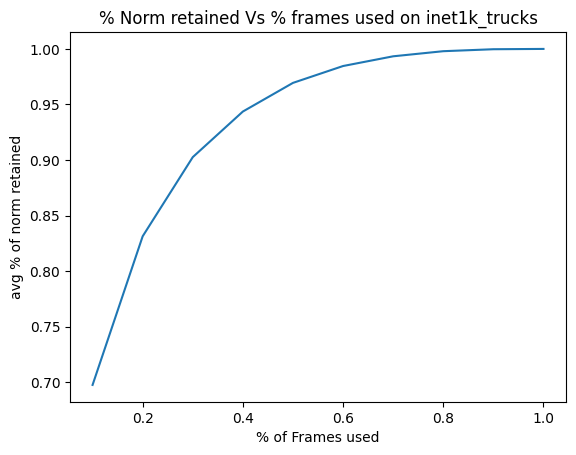

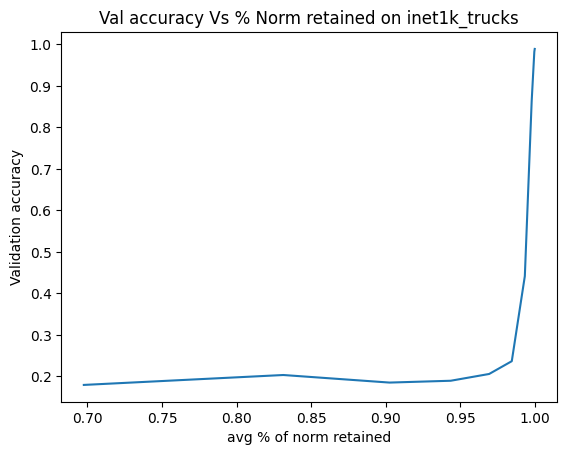

In [24]:
plt.plot(frame_percents, val_accs)
plt.title(f'Val Accuracy Vs % frames used on {args.dataset}')
plt.xlabel(f'% of Frames used')
plt.ylabel(f'Validation Accuracy')
plt.savefig(f'{args.dataset}_val_vs_frames.png')
plt.show()

plt.plot(frame_percents, norm_percents)
plt.title(f'% Norm retained Vs % frames used on {args.dataset}')
plt.xlabel(f'% of Frames used')
plt.ylabel(f'avg % of norm retained')
plt.savefig(f'{args.dataset}_norm_vs_frames.png')
plt.show()

plt.plot(norm_percents, val_accs)
plt.title(f'Val accuracy Vs % Norm retained on {args.dataset}')
plt.xlabel(f'avg % of norm retained')
plt.ylabel(f'Validation accuracy')
plt.savefig(f'{args.dataset}_Val_vs_norm.png')
plt.show()

torch.Size([690, 768])
384
345
384


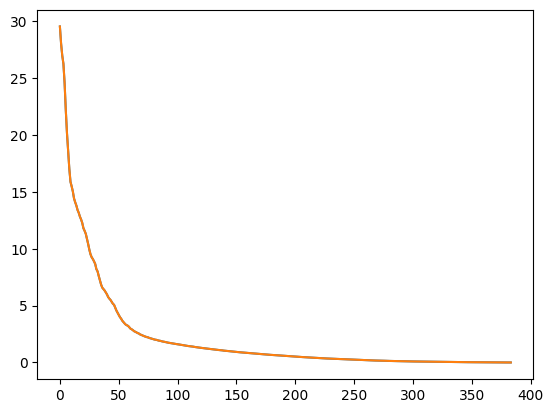

In [27]:
print(new_frames_filtered.shape)
print(len(new_norms))
print(frames_count)
print(len(indices))
plt.plot(new_norms.detach().cpu())
plt.plot(new_norms_sorted.detach().cpu())
plt.show()

In [15]:
wmat = model.transformer.encoder.layer[5].attn.key.weight.data
k_attn = 384
l_attn = 2
n_attn = 768
tffs = construct_real_tff(k_attn, l_attn // 2, n_attn // 2).to(args.device)
projs = torch.matmul(tffs, wmat)
norms = torch.norm(projs, dim=(1,2))

In [19]:
total_energy_frames = torch.sqrt((norms**2).sum())
print(f'{total_energy_frames = }')

total_energy_frames = tensor(63.5405, device='cuda:0')


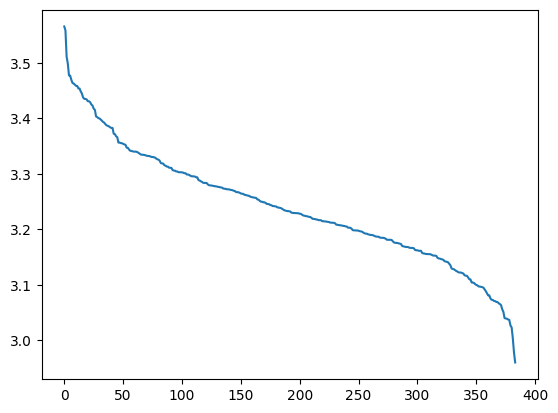

In [23]:
norms_sorted, _ = torch.sort(norms, descending=True)
plt.plot(norms_sorted.cpu())

In [63]:
U, S, Vh = torch.linalg.svd(wmat)
total_energy_svd = torch.sqrt((S**2).sum())
print(f'{total_energy_svd = }')

total_energy_svd = tensor(63.5472, device='cuda:0')


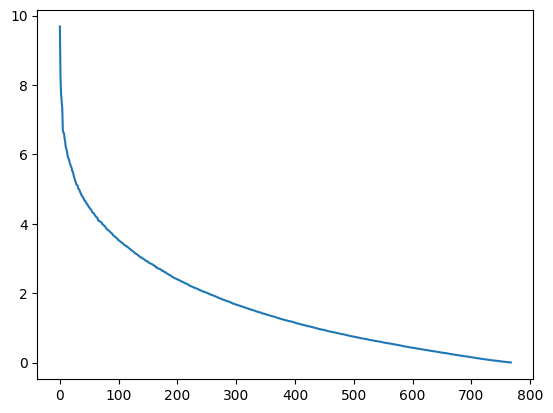

In [24]:
plt.plot(S.cpu())
plt.show()

In [65]:
projs0 = U.transpose(0,1)[0] @ wmat
norms0 = torch.norm(projs0)
print(norms0)

projs1 = Vh[1] @ wmat
norms1 = torch.norm(projs1)
print(torch.sqrt(norms0**2 + norms1**2))

tensor(9.6828, device='cuda:0')
tensor(9.9720, device='cuda:0')


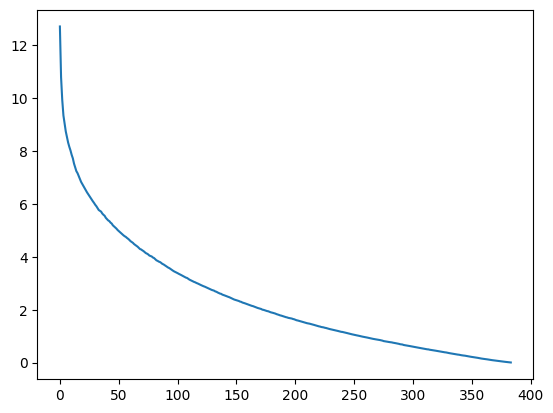

In [66]:
# finding the rotation matrix
frame_cat = tffs.view(-1, n_attn)
RotMat = U @ frame_cat
new_projs = torch.matmul(tffs, RotMat.transpose(0,1) ) @ wmat
new_norms = torch.norm(new_projs, dim=(1,2))
new_norms_sorted, _ = torch.sort(new_norms, descending=True)
plt.plot(new_norms_sorted.cpu())
plt.show()

In [ ]:
new_frames = torch.matmul(tffs, RotMat.transpose(0,1) )
new_frames.shape
S_new = 0
S_old = 0
for i in range(k_attn):
    S_new += new_frames[i].transpose(0,1) @ new_frames[i]
    S_old += tffs[i].transpose(0,1) @ tffs[i]

print(S_new[:10,:10])
print(S_old[:10,:10])

In [35]:
# checking orthogonality
print(f'{tffs.shape = }')
frame0 = tffs[0]
frame1 = tffs[1]
print(f'frame1 dot product = {torch.dot(frame0[0], frame0[1])}')
print(f'frame1 dot product = {torch.dot(frame1[0], frame1[1])}')
dot_00_10 = torch.dot(frame0[0], frame1[0])
dot_00_11 = torch.dot(frame0[0], frame1[1])
dot_01_10 = torch.dot(frame0[1], frame1[0])
dot_01_11 = torch.dot(frame0[1], frame1[1])

print(f'{dot_00_10 = }')
print(f'{dot_00_11 = }')
print(f'{dot_01_10 = }')
print(f'{dot_01_11 = }')

tffs.shape = torch.Size([384, 2, 768])
frame1 dot product = 0.0
frame1 dot product = 0.0
dot_00_10 = tensor(0., device='cuda:0')
dot_00_11 = tensor(7.4506e-09, device='cuda:0')
dot_01_10 = tensor(-7.4506e-09, device='cuda:0')
dot_01_11 = tensor(0., device='cuda:0')


In [44]:
svd1 = Vh[0].view(-1,1)
frame1 = tffs[0,0].view(1,-1)
Ru, Rs, RvT = torch.linalg.svd(svd1 @ frame1)
R = Ru @ RvT

In [53]:
test_frame_inv = frame_cat @ frame_cat.transpose(0,1)

tensor([[ 1.0000e+00, -7.6016e-10, -4.4703e-08,  5.9605e-08,  5.2154e-08,
          1.4901e-08, -1.7260e-08,  7.1362e-09,  7.4506e-09,  3.7253e-09],
        [-7.6016e-10,  1.0000e+00, -5.9605e-08, -4.4703e-08, -1.4901e-08,
          5.9605e-08, -1.7921e-09, -1.0447e-08,  3.7253e-09,  1.4901e-08],
        [-4.4703e-08, -5.9605e-08,  1.0000e+00,  0.0000e+00, -4.4703e-08,
          5.9605e-08,  1.4901e-08, -2.2352e-08,  1.9886e-08,  1.4767e-08],
        [ 5.9605e-08, -4.4703e-08,  0.0000e+00,  1.0000e+00, -5.9605e-08,
         -4.4703e-08,  2.2352e-08,  1.4901e-08, -1.4767e-08,  1.9886e-08],
        [ 5.2154e-08, -1.4901e-08, -4.4703e-08, -5.9605e-08,  1.0000e+00,
          7.6016e-10, -1.4901e-08,  4.4703e-08, -7.4506e-09, -7.4506e-09],
        [ 1.4901e-08,  5.9605e-08,  5.9605e-08, -4.4703e-08,  7.6016e-10,
          1.0000e+00, -5.9605e-08, -1.4901e-08, -1.4901e-08,  0.0000e+00],
        [-1.7260e-08, -1.7921e-09,  1.4901e-08,  2.2352e-08, -1.4901e-08,
         -5.9605e-08,  1.0000e+0

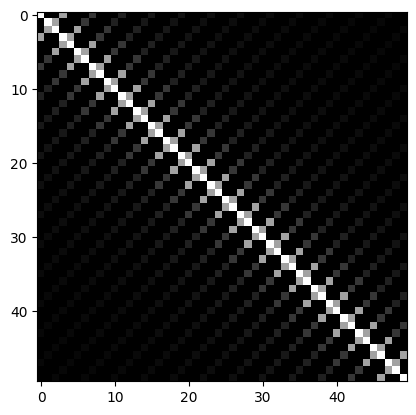

tensor([ 5.0000e-01,  1.4594e-10,  1.3021e-03,  3.1831e-01,  2.8148e-10,
         3.5967e-08,  1.3021e-03,  1.0610e-01, -4.4313e-08,  5.1940e-09,
         1.3021e-03,  6.3653e-02,  1.1973e-08,  1.6502e-08,  1.3021e-03,
         4.5460e-02, -4.0024e-09, -1.0231e-08,  1.3021e-03,  3.5352e-02],
       device='cuda:0')
tensor([ 1.4594e-10,  5.0000e-01, -3.1831e-01,  1.3021e-03, -3.5967e-08,
         3.6962e-12, -1.0610e-01,  1.3021e-03, -8.7353e-09, -4.5519e-08,
        -6.3653e-02,  1.3021e-03, -2.0088e-08,  6.0439e-09, -4.5460e-02,
         1.3021e-03,  1.1451e-08, -1.5004e-09, -3.5352e-02,  1.3021e-03],
       device='cuda:0')


In [82]:
k_attn = 768
l_attn = 2
n_attn = 768
tffs = construct_real_tff(k_attn, l_attn // 2, n_attn // 2).to(args.device)
frame_cat = tffs.view(-1, n_attn)

frame_correlation = frame_cat @ frame_cat.transpose(0,1)
plt.gray()
plt.imshow(frame_correlation.cpu().abs()[:50,:50])
plt.show()
print(frame_correlation[0,:20])
print(frame_correlation[1,:20])

In [11]:
# args.name
# args.dataset
# args.dataset_dir
# args.model_type
# args.pretrained_dir
# args.output_dir
# args.img_size
# args.train_batch_size
# args.eval_batch_size
# args.eval_every
# args.save_every
# args.learning_rate
# args.weight_decay
# args.num_steps
# args.decay_type
# args.warmup_steps
# args.max_grad_norm
# args.local_rank
# args.seed
# args.gradient_accumulation_steps
# args.fp16
# args.fp16_opt_level
# args.loss_scale
